# Milwaukee Network: Scenario Evaluation with CBA and MCA (car-only)

This notebook evaluates transport infrastructure scenarios for Milwaukee using:
- Cost-Benefit Analysis (CBA)
- Multi-Criteria Analysis (MCA)

**Scenarios Tested:**
1. **Baseline**: Current network condition (reference scenario)
2. **Capacity +20%**: Increase road capacity by 20% on all links (€5M CAPEX, €150k/year OPEX)
3. **Adaptive Traffic Signals**: Smart signal management system with 12% delay reduction and 8% capacity improvement (€800k CAPEX, €50k/year OPEX)
4. **Low Emission Zone (LEZ)**: City-center restriction of high-emission vehicles with 10% demand reduction (€700k CAPEX, €250k/year OPEX)

## Setup and Imports

In [74]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Configuration Parameters

In [ ]:
# Directories
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data_preprocessed'
RESULTS_DIR = BASE_DIR / 'results'
BASELINE_DIR = RESULTS_DIR / 'baseline'

# CBA Parameters
DISCOUNT_RATE = 0.04  # 4% annual discount rate
EVALUATION_HORIZON = 20  # years
VALUE_OF_TIME = 15.0  # €/hour
CO2_PRICE = 100  # €/tonne
EMISSION_FACTOR_KG_PER_KM = 0.2  # kg CO2/km for cars
AVG_TRIP_LENGTH_KM = 8.0  # Average trip length
ANNUALIZATION_FACTOR = 250  # Working days per year (for peak hour to annual conversion)

CAPEX_CAPACITY = 5_000_000  # $5M for capacity expansion
OPEX_CAPACITY = 150_000  # $150k/year maintenance (3% of CAPEX)
CAPEX_SIGNALS = 800_000  # $800k for adaptive traffic signal system
OPEX_SIGNALS = 50_000  # $50k/year maintenance and operation (6% of CAPEX)
CAPEX_LEZ = 700_000  # $700k for LEZ enforcement (cameras, ANPR, monitoring)
OPEX_LEZ = 250_000  # $250k/year for operation and enforcement

# Scenario parameters
CAPACITY_INCREASE = 0.20  # 20% capacity increase
SIGNALS_DELAY_REDUCTION = 0.12  # 12% delay reduction from adaptive signals
SIGNALS_CAPACITY_IMPROVEMENT = 0.08  # 8% effective capacity increase from better flow
LEZ_DEMAND_REDUCTION = 0.10  # 10% demand reduction from LEZ restriction
LEZ_TOP_OD_FRACTION = 0.30  # Apply to top 30% of OD pairs by volume (city center)
LEZ_EMISSION_REDUCTION_FACTOR = 1.0  # Emission factor multiplier for removed trips (1.0 = same as average)

# MCA weights
MCA_WEIGHTS = {
    'npv': 0.40,
    'bcr': 0.30,
    'time_savings': 0.20,
    'co2_reduction': 0.10
}

print(f"CO2 price: €{CO2_PRICE}/tonne")
print(f"Discount rate: {DISCOUNT_RATE:.1%}")
print(f"Evaluation horizon: {EVALUATION_HORIZON} years")
print(f"Value of time: €{VALUE_OF_TIME}/hour")

CO2 price: €100/tonne
Discount rate: 4.0%
Evaluation horizon: 20 years
Value of time: €15.0/hour


## Data Loading

In [76]:
# Load network data (prefer baseline results if available)
def load_with_fallback(stem: str, fallback_path: str):
    """Load data from baseline results or fallback to original data."""
    baseline_path = BASELINE_DIR / f"{stem}.csv"
    if baseline_path.exists():
        print(f"Loading {stem} from baseline results")
        return pd.read_csv(baseline_path)
    print(f"  Loading {stem} from {fallback_path}")
    return pd.read_csv(fallback_path)

# Load core datasets
nodes_df = load_with_fallback('nodes', DATA_DIR / 'node.csv')
links_df = load_with_fallback('links', DATA_DIR / 'link.csv')
demand_df = load_with_fallback('demand', DATA_DIR / 'demand.csv')

# Load link performance if available
link_perf_path = BASELINE_DIR / 'link_performance.csv'
if link_perf_path.exists():
    link_performance = pd.read_csv(link_perf_path)
    print("Loaded link performance from baseline")
else:
    link_performance = None
    print("  Link performance not found; will synthesize")

print(f"\nData summary:")
print(f"  Nodes: {len(nodes_df):,}")
print(f"  Links: {len(links_df):,}")
print(f"  OD pairs: {len(demand_df):,}")
print(f"  Total demand: {demand_df['volume'].sum():,.0f} trips")

Loading nodes from baseline results
Loading links from baseline results
Loading demand from baseline results
Loaded link performance from baseline

Data summary:
  Nodes: 8,521
  Links: 27,731
  OD pairs: 30,422
  Total demand: 163,700 trips


## Helper Functions

In [77]:
def build_graph(links: pd.DataFrame) -> tuple[nx.DiGraph, dict]:
    """Build NetworkX graph from link dataframe."""
    G = nx.DiGraph()
    for _, r in links.iterrows():
        G.add_edge(r['from_node_id'], r['to_node_id'], 
                   length=r.get('length', 1.0),
                   link_id=r['link_id'])
    edge_to_link = {(r['from_node_id'], r['to_node_id']): r['link_id'] 
                    for _, r in links.iterrows()}
    return G, edge_to_link


def apply_signal_optimization(lp: pd.DataFrame, delay_reduction: float, capacity_improvement: float) -> pd.DataFrame:
    """Apply adaptive signal optimization effects: reduced delays and improved effective capacity."""
    df = lp.copy()
    # Effective capacity increase from better coordination
    df['capacity'] *= (1 + capacity_improvement)
    # Smoother flow reduces effective congestion
    df['volume'] *= (1 - delay_reduction * 0.3)
    df['vc_ratio'] = df['volume'] / df['capacity'].replace(0, np.nan)
    return df


def ensure_link_perf(lp: pd.DataFrame | None, links: pd.DataFrame) -> pd.DataFrame:
    """Ensure link performance dataframe has required columns."""
    if lp is None:
        df = links[['link_id', 'from_node_id', 'to_node_id', 'capacity']].copy()
        df['volume'] = df['capacity'] * 0.6  # synthetic baseline
    else:
        df = lp.copy()
        if 'capacity' not in df.columns and 'link_capacity' in df.columns:
            df = df.rename(columns={'link_capacity': 'capacity'})
        if 'volume' not in df.columns:
            for cand in ['mod_vol_auto', 'ref_volume', 'base_demand_volume']:
                if cand in df.columns:
                    df['volume'] = df[cand]
                    break
            if 'volume' not in df.columns:
                df['volume'] = df['capacity'] * 0.6
        df = df[['link_id', 'from_node_id', 'to_node_id', 'capacity', 'volume']].copy()
    df['vc_ratio'] = df['volume'] / df['capacity'].replace(0, np.nan)
    return df


def annuity_factor(rate: float, n_years: int) -> float:
    """Calculate present value annuity factor."""
    return (1 - (1 + rate)**(-n_years)) / rate


def travel_time_from_vc(mean_vc: float, free_flow_time: float = 10.0, alpha: float = 0.15, beta: float = 4.0) -> float:
    """
    Calculate travel time using BPR (Bureau of Public Roads) function.
    
    Travel time = free_flow_time * [1 + alpha * (V/C)^beta]
    
    Parameters:
    - free_flow_time: baseline travel time in minutes (default: 10 min)
    - alpha: calibration parameter (default: 0.15)
    - beta: congestion sensitivity parameter (default: 4.0)
    
    Returns travel time in minutes.
    """
    return free_flow_time * (1 + alpha * (mean_vc ** beta))


print("Helper functions defined.")

Helper functions defined.


## Baseline Scenario Analysis

In [78]:
# Prepare baseline link performance
lp_base = ensure_link_perf(link_performance, links_df)

# Build graph and find top-demand OD
G, edge_lookup = build_graph(links_df)
top_od = demand_df.nlargest(1, 'volume').iloc[0]

try:
    path_nodes = nx.shortest_path(G, source=top_od['o_zone_id'], 
                                  target=top_od['d_zone_id'], weight='length')
    edges_on_path = list(zip(path_nodes[:-1], path_nodes[1:]))
except nx.NetworkXNoPath:
    path_nodes = []
    edges_on_path = []

# Baseline metrics
baseline_metrics = {
    'total_demand': demand_df['volume'].sum(),
    'total_capacity': links_df['capacity'].sum(),
    'mean_vc': lp_base['vc_ratio'].mean(),
    'median_vc': lp_base['vc_ratio'].median(),
    'max_vc': lp_base['vc_ratio'].max(),
    'pct_congested': (lp_base['vc_ratio'] > 1.0).mean() * 100,
    'total_volume': lp_base['volume'].sum(),
}

print("=" * 70)
print("BASELINE SCENARIO METRICS")
print("=" * 70)
print(f"Total demand: {baseline_metrics['total_demand']:,.0f} trips")
print(f"Total capacity: {baseline_metrics['total_capacity']:,.0f} veh/h")
print(f"Mean V/C ratio: {baseline_metrics['mean_vc']:.3f}")
print(f"Max V/C ratio: {baseline_metrics['max_vc']:.3f}")
print(f"Congested links (V/C>1): {baseline_metrics['pct_congested']:.1f}%")
print(f"\nTop-demand OD: {top_od['o_zone_id']} → {top_od['d_zone_id']}")
print(f"Volume: {top_od['volume']:,.0f} trips")
print(f"Path nodes: {len(path_nodes)}, Path edges: {len(edges_on_path)}")

BASELINE SCENARIO METRICS
Total demand: 163,700 trips
Total capacity: 1,377,964,042 veh/h
Mean V/C ratio: 0.247
Max V/C ratio: 12.484
Congested links (V/C>1): 6.8%

Top-demand OD: 7 → 67
Volume: 202 trips
Path nodes: 0, Path edges: 0


## Scenario Definition and Simulation

In [79]:
# Scenario 1: Capacity +20%
links_s1 = links_df.copy()
links_s1['capacity'] *= (1 + CAPACITY_INCREASE)

lp_s1 = lp_base.copy()
lp_s1['capacity'] *= (1 + CAPACITY_INCREASE)
lp_s1['vc_ratio'] = lp_s1['volume'] / lp_s1['capacity'].replace(0, np.nan)

demand_s1 = demand_df.copy()

# Scenario 2: Adaptive Traffic Signal Management
links_s2 = links_df.copy()
# No physical capacity change, but improved flow
links_s2['capacity'] *= (1 + SIGNALS_CAPACITY_IMPROVEMENT)

demand_s2 = demand_df.copy()  # Demand unchanged

lp_s2 = apply_signal_optimization(lp_base, SIGNALS_DELAY_REDUCTION, SIGNALS_CAPACITY_IMPROVEMENT)

# Scenario 3: Low Emission Zone (LEZ)
# Identify top OD pairs for city center zone (by volume)
demand_sorted = demand_df.sort_values('volume', ascending=False)
n_lez_ods = int(len(demand_df) * LEZ_TOP_OD_FRACTION)
lez_od_indices = demand_sorted.head(n_lez_ods).index

demand_s3 = demand_df.copy()
# Apply LEZ restriction: remove 10% of trips (emission factor multiplier configurable)
demand_s3.loc[lez_od_indices, 'volume'] *= (1 - LEZ_DEMAND_REDUCTION)

# Calculate volume reduction for links (approximate distribution)
total_volume_reduction = (demand_df.loc[lez_od_indices, 'volume'].sum() * LEZ_DEMAND_REDUCTION)
avg_reduction_per_link = total_volume_reduction / len(links_df)

lp_s3 = lp_base.copy()
lp_s3['volume'] = np.maximum(lp_s3['volume'] - avg_reduction_per_link, 0)
lp_s3['vc_ratio'] = lp_s3['volume'] / lp_s3['capacity'].replace(0, np.nan)

links_s3 = links_df.copy()  # No capacity change

print("Scenarios defined:")
print(f"  S1: Capacity +{CAPACITY_INCREASE:.0%} on all links")
print(f"  S2: Adaptive Signals - {SIGNALS_DELAY_REDUCTION:.0%} delay reduction, {SIGNALS_CAPACITY_IMPROVEMENT:.0%} capacity improvement")
print(f"  S3: Low Emission Zone - {LEZ_DEMAND_REDUCTION:.0%} demand reduction on top {LEZ_TOP_OD_FRACTION:.0%} OD pairs")
print(f"      Emission factor multiplier: {LEZ_EMISSION_REDUCTION_FACTOR:.1f}× (set to 1.0 for average emitters)")
print(f"      City center OD pairs: {n_lez_ods:,}")

Scenarios defined:
  S1: Capacity +20% on all links
  S2: Adaptive Signals - 12% delay reduction, 8% capacity improvement
  S3: Low Emission Zone - 10% demand reduction on top 30% OD pairs
      Emission factor multiplier: 1.0× (set to 1.0 for average emitters)
      City center OD pairs: 9,126


## KPI Comparison Across Scenarios


SCENARIO KPI COMPARISON
         Scenario  Total Demand  Total Capacity  Mean V/C   Max V/C  % Congested
         Baseline      163700.0    1.377964e+09  0.246580 12.484286     6.757780
    Capacity +20%      163700.0    1.653557e+09  0.205484 10.403571     5.268472
 Adaptive Signals      163700.0    1.488201e+09  0.220096 11.143381     5.780534
Low Emission Zone      151373.4    1.377964e+09  0.246488 12.483968     6.757780


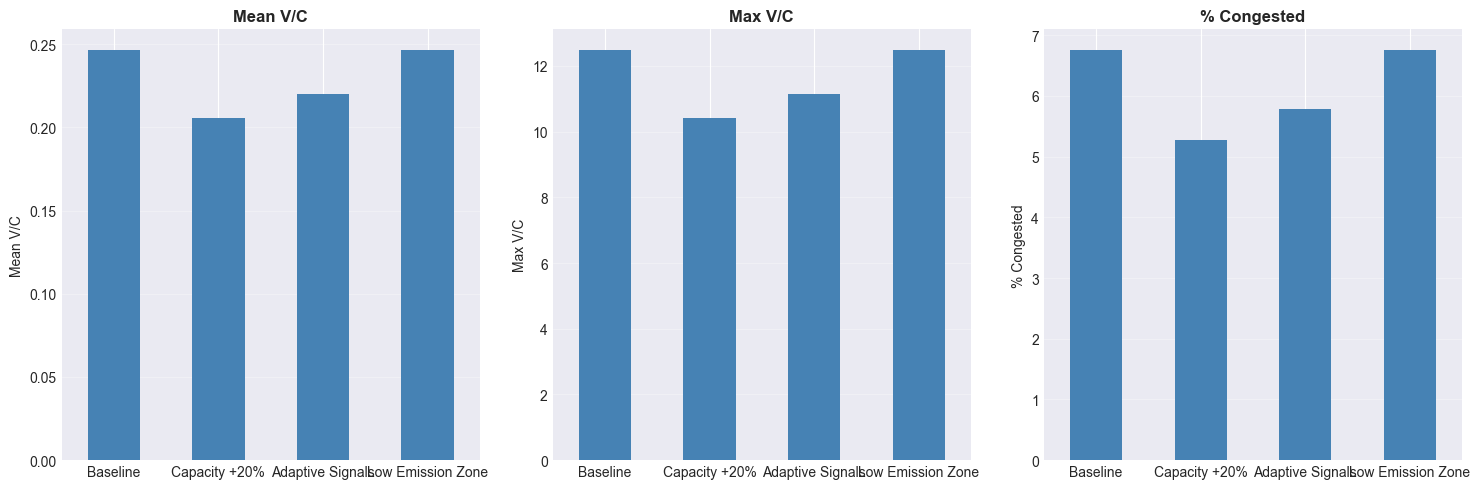

In [80]:
def calc_scenario_metrics(name: str, lp: pd.DataFrame, demand: pd.DataFrame, links: pd.DataFrame) -> dict:
    return {
        'Scenario': name,
        'Total Demand': demand['volume'].sum(),
        'Total Capacity': links['capacity'].sum(),
        'Mean V/C': lp['vc_ratio'].mean(),
        'Max V/C': lp['vc_ratio'].max(),
        '% Congested': (lp['vc_ratio'] > 1.0).mean() * 100,
    }

scenarios_kpi = [
    calc_scenario_metrics('Baseline', lp_base, demand_df, links_df),
    calc_scenario_metrics('Capacity +20%', lp_s1, demand_s1, links_s1),
    calc_scenario_metrics('Adaptive Signals', lp_s2, demand_s2, links_s2),
    calc_scenario_metrics('Low Emission Zone', lp_s3, demand_s3, links_s3),
]

kpi_df = pd.DataFrame(scenarios_kpi)
print("\n" + "=" * 70)
print("SCENARIO KPI COMPARISON")
print("=" * 70)
print(kpi_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_to_plot = ['Mean V/C', 'Max V/C', '% Congested']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    kpi_df.plot(x='Scenario', y=metric, kind='bar', ax=ax, legend=False, color='steelblue')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=0)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Cost-Benefit Analysis (CBA)

CONGESTION ANALYSIS - Baseline
Overall V/C Statistics:
  Mean V/C    : 0.247
  Median V/C  : 0.000
  Std V/C     : 0.802
  Min V/C     : 0.000
  Max V/C     : 12.484

Congestion Level Distribution:
  Free Flow      :  8180 links ( 29.5%)
  Light          :  1010 links (  3.6%)
  Moderate       :   417 links (  1.5%)
  Heavy          :   149 links (  0.5%)
  Oversaturated  :   942 links (  3.4%)

Top 15 Bottleneck Links (by V/C):
 link_id  volume  capacity  vc_ratio
   25446 17478.0    1400.0 12.484286
   25431 17336.0    1400.0 12.382857
   25433 17336.0    1400.0 12.382857
   25436 17336.0    1400.0 12.382857
   25438 17336.0    1400.0 12.382857
   25440 17336.0    1400.0 12.382857
   25444 17336.0    1400.0 12.382857
   27578 17336.0    1400.0 12.382857
   27581 17336.0    1400.0 12.382857
   27039 16692.0    1400.0 11.922857
   16562 16652.0    1400.0 11.894286
   25225 16652.0    1400.0 11.894286
   12740 15852.0    1400.0 11.322857
   25450 15064.0    1400.0 10.760000
   25452 150

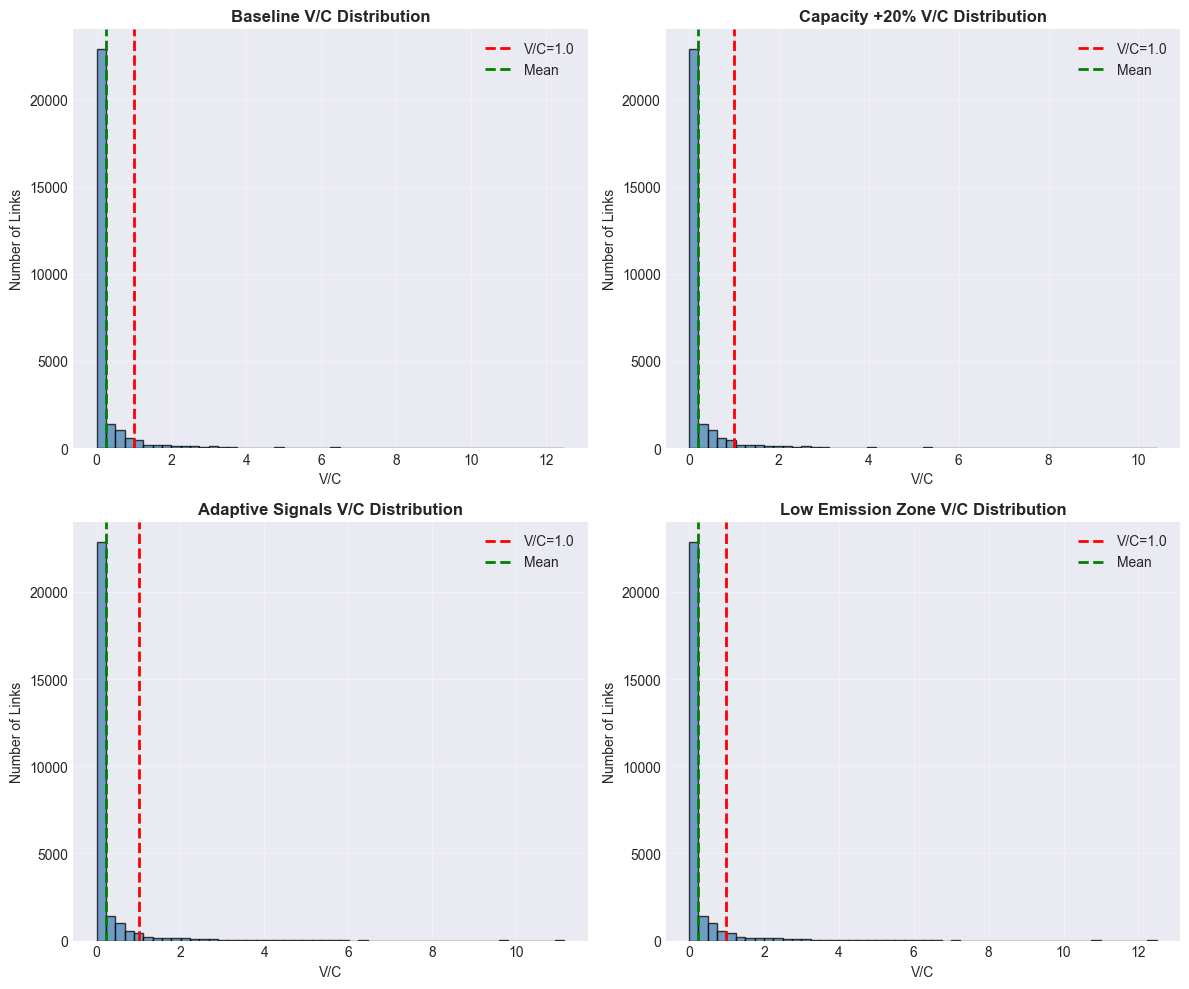

In [81]:
# Detailed V/C and bottleneck analysis across scenarios
scenario_lp = {
    'Baseline': lp_base.copy(),
    'Capacity +20%': lp_s1.copy(),
    'Adaptive Signals': lp_s2.copy(),
    'Low Emission Zone': lp_s3.copy(),
}

def analyze_vc(df: pd.DataFrame, name: str) -> dict:
    cap_col = 'capacity' if 'capacity' in df.columns else df.filter(regex='capacity').columns[0]
    if 'vc_ratio' not in df.columns:
        df['vc_ratio'] = df['volume'] / df[cap_col].replace(0, np.nan)
    df['congestion_level'] = pd.cut(
        df['vc_ratio'],
        bins=[0, 0.5, 0.75, 0.9, 1.0, 2.0],
        labels=['Free Flow', 'Light', 'Moderate', 'Heavy', 'Oversaturated']
    )
    stats = {
        'Mean V/C': df['vc_ratio'].mean(),
        'Median V/C': df['vc_ratio'].median(),
        'Std V/C': df['vc_ratio'].std(),
        'Min V/C': df['vc_ratio'].min(),
        'Max V/C': df['vc_ratio'].max(),
    }
    dist = df['congestion_level'].value_counts().reindex(['Free Flow','Light','Moderate','Heavy','Oversaturated']).fillna(0)
    top_bottlenecks = df.nlargest(15, 'vc_ratio')[['link_id', 'volume', cap_col, 'vc_ratio']]
    return stats, dist, top_bottlenecks, df

for scenario_name, lp_df in scenario_lp.items():
    stats, dist, top_bottlenecks, lp_df = analyze_vc(lp_df, scenario_name)
    print("=" * 70)
    print(f"CONGESTION ANALYSIS - {scenario_name}")
    print("=" * 70)
    print("Overall V/C Statistics:")
    for k, v in stats.items():
        print(f"  {k:12s}: {v:.3f}")
    print("\nCongestion Level Distribution:")
    total_links = len(lp_df)
    for level, count in dist.items():
        pct = 100 * count / total_links
        print(f"  {level:15s}: {int(count):5d} links ({pct:5.1f}%)")
    print("\nTop 15 Bottleneck Links (by V/C):")
    print(top_bottlenecks.to_string(index=False))
    print()

# V/C distribution plots by scenario
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for ax, (scenario_name, lp_df) in zip(axes, scenario_lp.items()):
    if 'vc_ratio' not in lp_df.columns:
        lp_df['vc_ratio'] = lp_df['volume'] / lp_df['capacity'].replace(0, np.nan)
    ax.hist(lp_df['vc_ratio'], bins=50, color='steelblue', edgecolor='black', alpha=0.75)
    ax.axvline(1.0, color='red', linestyle='--', linewidth=2, label='V/C=1.0')
    ax.axvline(lp_df['vc_ratio'].mean(), color='green', linestyle='--', linewidth=2, label='Mean')
    ax.set_title(f"{scenario_name} V/C Distribution", fontweight='bold')
    ax.set_xlabel('V/C')
    ax.set_ylabel('Number of Links')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

## Congestion Analysis (V/C Bottlenecks)

ACCESSIBILITY GINI (BASELINE TABLES)
  Origins - Destinations Reachable        : 0.106 [Low inequality]
  Origins - Total Volume                  : 0.227 [Low inequality]
  Origins - Avg Distance (mile)           : 0.172 [Low inequality]
  Destinations - Origins Connecting       : 0.289 [Low inequality]
  Destinations - Total Volume             : 0.661 [High inequality]
  Destinations - Avg Distance (mile)      : 0.176 [Low inequality]

SCENARIO CONGESTION GINI (V/C)
         Scenario  Gini V/C  Mean V/C   Max V/C  % Links V/C>1
         Baseline  0.889422  0.246580 12.484286       6.757780
    Capacity +20%  0.889422  0.205484 10.403571       5.268472
 Adaptive Signals  0.889422  0.220096 11.143381       5.780534
Low Emission Zone  0.889521  0.246488 12.483968       6.757780


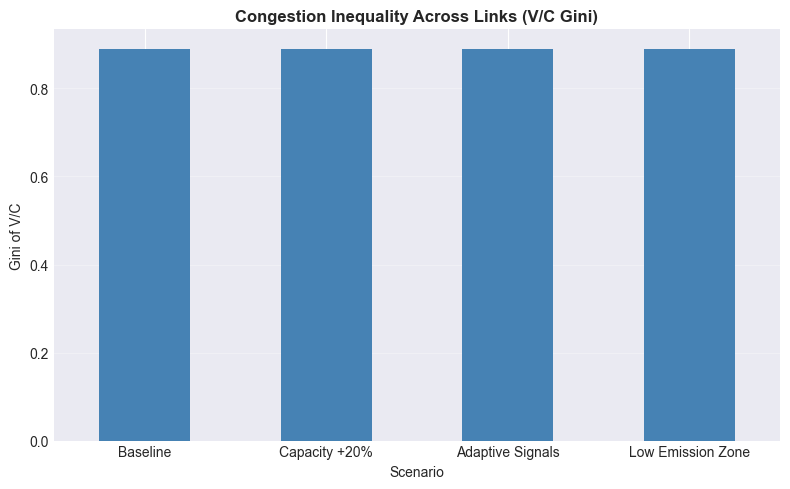

In [82]:
# Load accessibility data (origin/destination)
origin_access = pd.read_csv(DATA_DIR / 'origin_accessibility.csv')
destination_access = pd.read_csv(DATA_DIR / 'destination_accessibility.csv')

# Harmonize zone id column names
if 'origin_zone_id' in origin_access.columns and 'zone_id' not in origin_access.columns:
    origin_access = origin_access.rename(columns={'origin_zone_id': 'zone_id'})
if 'destination_zone_id' in destination_access.columns and 'zone_id' not in destination_access.columns:
    destination_access = destination_access.rename(columns={'destination_zone_id': 'zone_id'})

origin_access['zone_id'] = pd.to_numeric(origin_access['zone_id'], errors='coerce').astype('Int64')
destination_access['zone_id'] = pd.to_numeric(destination_access['zone_id'], errors='coerce').astype('Int64')

def gini(values: pd.Series) -> float:
    arr = np.sort(values.dropna().astype(float).values)
    if len(arr) == 0:
        return 0.0
    n = len(arr)
    cum = np.cumsum(arr)
    return (2 * np.sum((np.arange(1, n + 1) * arr))) / (n * cum[-1]) - (n + 1) / n

# Baseline accessibility gini (origin/destination tables)
gini_access = {
    'Origins - Destinations Reachable': gini(origin_access['number_of_destinations']),
    'Origins - Total Volume': gini(origin_access.get('total_volume', pd.Series(dtype=float))),
    'Origins - Avg Distance (mile)': gini(origin_access.get('avg_distance_mile', pd.Series(dtype=float))),
    'Destinations - Origins Connecting': gini(destination_access['number_of_origins']),
    'Destinations - Total Volume': gini(destination_access.get('total_volume', pd.Series(dtype=float))),
    'Destinations - Avg Distance (mile)': gini(destination_access.get('avg_distance_mile', pd.Series(dtype=float))),
}

print("=" * 70)
print("ACCESSIBILITY GINI (BASELINE TABLES)")
print("=" * 70)
for k, v in gini_access.items():
    level = "Low" if v < 0.3 else "Moderate" if v < 0.5 else "High"
    print(f"  {k:40s}: {v:.3f} [{level} inequality]")

# Scenario-level V/C gini (equity of congestion across links)
scenario_lp = {
    'Baseline': lp_base,
    'Capacity +20%': lp_s1,
    'Adaptive Signals': lp_s2,
    'Low Emission Zone': lp_s3,
}

scenario_gini_rows = []
for name, df in scenario_lp.items():
    df_local = df.copy()
    if 'vc_ratio' not in df_local.columns:
        df_local['vc_ratio'] = df_local['volume'] / df_local['capacity'].replace(0, np.nan)
    gini_vc = gini(df_local['vc_ratio'])
    pct_over_1 = (df_local['vc_ratio'] > 1.0).mean() * 100
    scenario_gini_rows.append({
        'Scenario': name,
        'Gini V/C': gini_vc,
        'Mean V/C': df_local['vc_ratio'].mean(),
        'Max V/C': df_local['vc_ratio'].max(),
        '% Links V/C>1': pct_over_1,
    })

scenario_gini_df = pd.DataFrame(scenario_gini_rows)

print("\n" + "=" * 70)
print("SCENARIO CONGESTION GINI (V/C)")
print("=" * 70)
print(scenario_gini_df.to_string(index=False))

# Visualize V/C gini per scenario
fig, ax = plt.subplots(figsize=(8, 5))
scenario_gini_df.plot(x='Scenario', y='Gini V/C', kind='bar', ax=ax, color='steelblue', legend=False)
ax.set_ylabel('Gini of V/C')
ax.set_title('Congestion Inequality Across Links (V/C Gini)', fontweight='bold')
ax.tick_params(axis='x', rotation=0)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Accessibility and Equity (Gini) by Scenario

In [83]:
# Annual trips for scaling
ANNUAL_TRIPS = demand_df['volume'].sum() * ANNUALIZATION_FACTOR
pv_factor = annuity_factor(DISCOUNT_RATE, EVALUATION_HORIZON)

# Extract mean V/C for each scenario
vc_baseline = kpi_df[kpi_df['Scenario'] == 'Baseline']['Mean V/C'].values[0]
vc_cap = kpi_df[kpi_df['Scenario'] == 'Capacity +20%']['Mean V/C'].values[0]
vc_signals = kpi_df[kpi_df['Scenario'] == 'Adaptive Signals']['Mean V/C'].values[0]
vc_lez = kpi_df[kpi_df['Scenario'] == 'Low Emission Zone']['Mean V/C'].values[0]

# Time savings using BPR travel time function
# Calculate travel times for each scenario
time_base = travel_time_from_vc(vc_baseline)
time_cap = travel_time_from_vc(vc_cap)
time_signals = travel_time_from_vc(vc_signals)
time_lez = travel_time_from_vc(vc_lez)

# Annual time savings (difference in travel time per trip × annual trips)
ann_time_saved_cap_min = max(time_base - time_cap, 0) * ANNUAL_TRIPS
ann_time_saved_signals_min = max(time_base - time_signals, 0) * ANNUAL_TRIPS
# For LEZ, use reduced demand (only remaining trips benefit)
ann_trips_lez = demand_s3['volume'].sum() * ANNUALIZATION_FACTOR
ann_time_saved_lez_min = max(time_base - time_lez, 0) * ann_trips_lez

ann_time_value_cap = (ann_time_saved_cap_min / 60.0) * VALUE_OF_TIME
ann_time_value_signals = (ann_time_saved_signals_min / 60.0) * VALUE_OF_TIME
ann_time_value_lez = (ann_time_saved_lez_min / 60.0) * VALUE_OF_TIME

# Display travel time comparison
print("=" * 70)
print("TRAVEL TIME COMPARISON (per trip)")
print("=" * 70)
print(f"Baseline:          {time_base:.2f} minutes (V/C = {vc_baseline:.3f})")
print(f"Capacity +20%:     {time_cap:.2f} minutes (V/C = {vc_cap:.3f})")
print(f"Adaptive Signals:  {time_signals:.2f} minutes (V/C = {vc_signals:.3f})")
print(f"Low Emission Zone: {time_lez:.2f} minutes (V/C = {vc_lez:.3f})")
print()
print("Time savings vs baseline:")
print(f"  Capacity +20%:    {time_base - time_cap:.2f} min/trip")
print(f"  Adaptive Signals: {time_base - time_signals:.2f} min/trip")
print(f"  Low Emission Zone:{time_base - time_lez:.2f} min/trip")
print("=" * 70)

# CO2 savings
# Capacity: assume 1% efficiency gain from smoother flow
ann_co2_saved_cap_kg = ANNUAL_TRIPS * AVG_TRIP_LENGTH_KM * EMISSION_FACTOR_KG_PER_KM * 0.01
ann_co2_value_cap = (ann_co2_saved_cap_kg / 1000) * CO2_PRICE

# Adaptive Signals: 2% efficiency gain from optimized flow
ann_co2_saved_signals_kg = ANNUAL_TRIPS * AVG_TRIP_LENGTH_KM * EMISSION_FACTOR_KG_PER_KM * 0.02
ann_co2_value_signals = (ann_co2_saved_signals_kg / 1000) * CO2_PRICE

# LEZ: trips eliminated are high emitters (factor configurable)
trip_reduction = (demand_df['volume'].sum() - demand_s3['volume'].sum()) * ANNUALIZATION_FACTOR
ann_co2_saved_lez_kg = trip_reduction * AVG_TRIP_LENGTH_KM * EMISSION_FACTOR_KG_PER_KM * LEZ_EMISSION_REDUCTION_FACTOR
ann_co2_value_lez = (ann_co2_saved_lez_kg / 1000) * CO2_PRICE

# Present values
pv_time_cap = ann_time_value_cap * pv_factor
pv_time_signals = ann_time_value_signals * pv_factor
pv_time_lez = ann_time_value_lez * pv_factor
pv_co2_cap = ann_co2_value_cap * pv_factor
pv_co2_signals = ann_co2_value_signals * pv_factor
pv_co2_lez = ann_co2_value_lez * pv_factor

pv_opex_cap = OPEX_CAPACITY * pv_factor
pv_opex_signals = OPEX_SIGNALS * pv_factor
pv_opex_lez = OPEX_LEZ * pv_factor

# NPV and BCR
total_benefits_cap = pv_time_cap + pv_co2_cap
total_costs_cap = CAPEX_CAPACITY + pv_opex_cap
npv_cap = total_benefits_cap - total_costs_cap
bcr_cap = total_benefits_cap / total_costs_cap

total_benefits_signals = pv_time_signals + pv_co2_signals
total_costs_signals = CAPEX_SIGNALS + pv_opex_signals
npv_signals = total_benefits_signals - total_costs_signals
bcr_signals = total_benefits_signals / total_costs_signals

total_benefits_lez = pv_time_lez + pv_co2_lez
total_costs_lez = CAPEX_LEZ + pv_opex_lez
npv_lez = total_benefits_lez - total_costs_lez
bcr_lez = total_benefits_lez / total_costs_lez

# Build CBA table
cba_results = pd.DataFrame([
    {
        'Scenario': 'Capacity +20%',
        'Annual Time Savings (h)': ann_time_saved_cap_min / 60,
        'Annual CO2 Savings (t)': ann_co2_saved_cap_kg / 1000,
        'Annual Revenue (€)': 0,
        'PV Benefits (€)': total_benefits_cap,
        'PV Costs (€)': total_costs_cap,
        'NPV (€)': npv_cap,
        'BCR': bcr_cap,
    },
    {
        'Scenario': 'Adaptive Signals',
        'Annual Time Savings (h)': ann_time_saved_signals_min / 60,
        'Annual CO2 Savings (t)': ann_co2_saved_signals_kg / 1000,
        'Annual Revenue (€)': 0,
        'PV Benefits (€)': total_benefits_signals,
        'PV Costs (€)': total_costs_signals,
        'NPV (€)': npv_signals,
        'BCR': bcr_signals,
    },
    {
        'Scenario': 'Low Emission Zone',
        'Annual Time Savings (h)': ann_time_saved_lez_min / 60,
        'Annual CO2 Savings (t)': ann_co2_saved_lez_kg / 1000,
        'Annual Revenue (€)': 0,
        'PV Benefits (€)': total_benefits_lez,
        'PV Costs (€)': total_costs_lez,
        'NPV (€)': npv_lez,
        'BCR': bcr_lez,
    },
])

print("\n" + "=" * 70)
print("COST-BENEFIT ANALYSIS RESULTS")
print("=" * 70)
print(cba_results.to_string(index=False))
print(f"\nDiscount rate: {DISCOUNT_RATE:.1%}, Horizon: {EVALUATION_HORIZON} years")
print(f"PV factor: {pv_factor:.3f}")

TRAVEL TIME COMPARISON (per trip)
Baseline:          10.01 minutes (V/C = 0.247)
Capacity +20%:     10.00 minutes (V/C = 0.205)
Adaptive Signals:  10.00 minutes (V/C = 0.220)
Low Emission Zone: 10.01 minutes (V/C = 0.246)

Time savings vs baseline:
  Capacity +20%:    0.00 min/trip
  Adaptive Signals: 0.00 min/trip
  Low Emission Zone:0.00 min/trip

COST-BENEFIT ANALYSIS RESULTS
         Scenario  Annual Time Savings (h)  Annual CO2 Savings (t)  Annual Revenue (€)  PV Benefits (€)  PV Costs (€)       NPV (€)      BCR
    Capacity +20%              1958.299488                  654.80                   0     1.289104e+06  7.038549e+06 -5.749445e+06 0.183149
 Adaptive Signals              1381.445433                 1309.60                   0     2.061404e+06  1.479516e+06  5.818872e+05 1.393296
Low Emission Zone                 5.201487                 4930.64                   0     6.701961e+06  4.097582e+06  2.604379e+06 1.635589

Discount rate: 4.0%, Horizon: 20 years
PV factor: 13.

## Multi-Criteria Analysis (MCA)


MULTI-CRITERIA ANALYSIS (MCA)
Weights: NPV=40%, BCR=30%, Time=20%, CO2=10%

         Scenario       NPV (€)      BCR  MCA Score
Low Emission Zone  2.604379e+06 1.635589   0.800000
 Adaptive Signals  5.818872e+05 1.393296   0.709356
    Capacity +20% -5.749445e+06 0.183149   0.200000


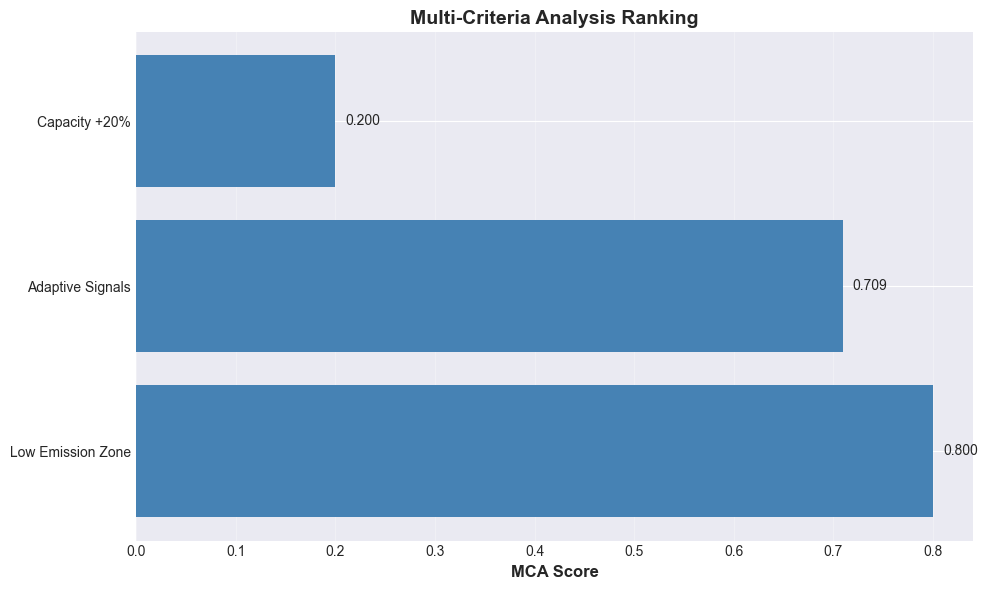

In [84]:
# Normalize criteria (min-max scaling)
def normalize_column(series: pd.Series) -> pd.Series:
    """Min-max normalization to [0, 1]."""
    span = series.max() - series.min()
    if span == 0:
        return pd.Series([1.0] * len(series), index=series.index)
    return (series - series.min()) / span

mca_df = cba_results.copy()
mca_df['NPV_norm'] = normalize_column(mca_df['NPV (€)'])
mca_df['BCR_norm'] = normalize_column(mca_df['BCR'])
mca_df['Time_norm'] = normalize_column(mca_df['Annual Time Savings (h)'])
mca_df['CO2_norm'] = normalize_column(mca_df['Annual CO2 Savings (t)'])

# Calculate weighted MCA score
mca_df['MCA Score'] = (
    mca_df['NPV_norm'] * MCA_WEIGHTS['npv'] +
    mca_df['BCR_norm'] * MCA_WEIGHTS['bcr'] +
    mca_df['Time_norm'] * MCA_WEIGHTS['time_savings'] +
    mca_df['CO2_norm'] * MCA_WEIGHTS['co2_reduction']
)

# Sort by MCA score
mca_df = mca_df.sort_values('MCA Score', ascending=False)

print("\n" + "=" * 70)
print("MULTI-CRITERIA ANALYSIS (MCA)")
print("=" * 70)
print(f"Weights: NPV={MCA_WEIGHTS['npv']:.0%}, BCR={MCA_WEIGHTS['bcr']:.0%}, "
      f"Time={MCA_WEIGHTS['time_savings']:.0%}, CO2={MCA_WEIGHTS['co2_reduction']:.0%}")
print()
print(mca_df[['Scenario', 'NPV (€)', 'BCR', 'MCA Score']].to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(mca_df['Scenario'], mca_df['MCA Score'], color='steelblue')
ax.set_xlabel('MCA Score', fontsize=12, fontweight='bold')
ax.set_title('Multi-Criteria Analysis Ranking', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for i, (scenario, score) in enumerate(zip(mca_df['Scenario'], mca_df['MCA Score'])):
    ax.text(score + 0.01, i, f"{score:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Summary and Recommendations

In [85]:
print("\n" + "=" * 70)
print("SUMMARY AND RECOMMENDATIONS")
print("=" * 70)

# Best scenario by different criteria
best_npv = cba_results.loc[cba_results['NPV (€)'].idxmax(), 'Scenario']
best_bcr = cba_results.loc[cba_results['BCR'].idxmax(), 'Scenario']
best_mca = mca_df.iloc[0]['Scenario']

print(f"\nBest scenario by NPV: {best_npv}")
print(f"Best scenario by BCR: {best_bcr}")
print(f"Best scenario by MCA: {best_mca}")

print("\n" + "-" * 70)
print("KEY FINDINGS:")
print("-" * 70)

for _, row in cba_results.iterrows():
    print(f"\n{row['Scenario']}:")
    print(f"  NPV: €{row['NPV (€)']:,.0f}")
    print(f"  BCR: {row['BCR']:.2f}")
    print(f"  Annual time savings: {row['Annual Time Savings (h)']:,.0f} hours")
    print(f"  Annual CO2 reduction: {row['Annual CO2 Savings (t)']:,.0f} tonnes")

print("\n" + "=" * 70)


SUMMARY AND RECOMMENDATIONS

Best scenario by NPV: Low Emission Zone
Best scenario by BCR: Low Emission Zone
Best scenario by MCA: Low Emission Zone

----------------------------------------------------------------------
KEY FINDINGS:
----------------------------------------------------------------------

Capacity +20%:
  NPV: €-5,749,445
  BCR: 0.18
  Annual time savings: 1,958 hours
  Annual CO2 reduction: 655 tonnes

Adaptive Signals:
  NPV: €581,887
  BCR: 1.39
  Annual time savings: 1,381 hours
  Annual CO2 reduction: 1,310 tonnes

Low Emission Zone:
  NPV: €2,604,379
  BCR: 1.64
  Annual time savings: 5 hours
  Annual CO2 reduction: 4,931 tonnes



## Save Results

In [86]:
# Create results directory
cba_results_dir = RESULTS_DIR / 'cba_mca'
cba_results_dir.mkdir(parents=True, exist_ok=True)

# Save tables
kpi_df.to_csv(cba_results_dir / 'scenario_kpis.csv', index=False)
cba_results.to_csv(cba_results_dir / 'cba_results.csv', index=False)
mca_df.to_csv(cba_results_dir / 'mca_results.csv', index=False)

# Save configuration
config = {
    'discount_rate': DISCOUNT_RATE,
    'evaluation_horizon': EVALUATION_HORIZON,
    'value_of_time': VALUE_OF_TIME,
    'co2_price': CO2_PRICE,
    'emission_factor_kg_per_km': EMISSION_FACTOR_KG_PER_KM,
    'avg_trip_length_km': AVG_TRIP_LENGTH_KM,
    'mca_weights': MCA_WEIGHTS,
    'scenarios': {
        'capacity': {
            'capex': CAPEX_CAPACITY,
            'opex': OPEX_CAPACITY,
            'capacity_increase': CAPACITY_INCREASE,
        },
        'signals': {
            'capex': CAPEX_SIGNALS,
            'opex': OPEX_SIGNALS,
            'delay_reduction': SIGNALS_DELAY_REDUCTION,
            'capacity_improvement': SIGNALS_CAPACITY_IMPROVEMENT,
        },
        'lez': {
            'capex': CAPEX_LEZ,
            'opex': OPEX_LEZ,
            'demand_reduction': LEZ_DEMAND_REDUCTION,
            'top_od_fraction': LEZ_TOP_OD_FRACTION,
            'emission_factor_multiplier': LEZ_EMISSION_REDUCTION_FACTOR,
        }
    }
}

with open(cba_results_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"Results saved to {cba_results_dir}")
print(f"  - scenario_kpis.csv")
print(f"  - cba_results.csv")
print(f"  - mca_results.csv")
print(f"  - config.json")

Results saved to ..\results\cba_mca
  - scenario_kpis.csv
  - cba_results.csv
  - mca_results.csv
  - config.json
